In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

__author__ = "Peter Nordin"
__license__ = "GPL"
__email__ = "peter.nordin@liu.se"

'''The purpose of this script is to allow easy calulation of the parasitic inductance and/or capacitance that
   will result from the choice of time step and material properties in Hopsan'''

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from TLMclasses import *
#import pandas as pd

Desired mass:       9.864600932271951
Desired stiffness:  263893782.90154266
wavespeed:          5172.19415303  
Desired Zc:         51021.6312639  
Tdesired:           0.00019334154334


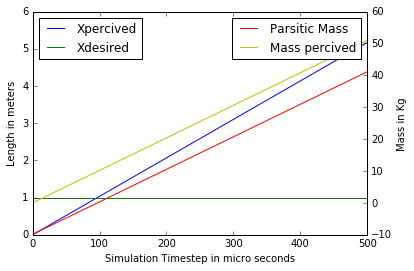

In [2]:
# Everything in this block is completely WRONG, ignore it

E=2.1e11
rho=7850
L=1
D=0.04*1
A=np.pi*D*D/4

mass_desired = A*L*rho
Zc_desired = np.sqrt(rho*A*A*E)
wavespeed = np.sqrt(E/rho)
Tdesired = L/wavespeed
stiffness_desired = E*A/L
n = 2                              # n = number of delay steps

template = "{0:20}{1:15}"
print(template.format('Desired mass:', str(mass_desired)))
print(template.format('Desired stiffness:', str(stiffness_desired)))
print(template.format('wavespeed:', str(wavespeed)))
print(template.format('Desired Zc:', str(Zc_desired)))
print(template.format('Tdesired:', str(Tdesired)))

ts = np.linspace(1e-6,5e-4,100)

Xdesired = [Tdesired*wavespeed+t*0 for t in ts]
Xpercived = [n*t*wavespeed for t in ts]
Mass_percived = [rho*A*n*t*wavespeed for t in ts]
ParasiticInd = [(n*t-Tdesired)*Zc_desired for t in ts] 
 

fig, axL = plt.subplots()
#plt.title('Length and parasitic mass realtive to simualtion timestep')
axL.plot(ts*1e6, Xpercived, label='Xpercived')
axL.plot(ts*1e6, Xdesired, label='Xdesired')
axL.set_ylabel('Length in meters')
axR = axL.twinx()
axR.plot(ts*1e6, ParasiticInd, color='red', label='Parsitic Mass')
axR.plot(ts*1e6, Mass_percived, color='y', label='Mass percived')
axR.set_ylabel('Mass in Kg')
axL.set_xlabel('Simulation Timestep in micro seconds')
axL.legend(loc='best')
axR.legend(loc='upper right')
plt.show()

In [3]:
# Steady state Inductance test
# Preserve Char.impeedance, Get Parasitic Inductance (and capacitance, not listed here)
# Test is to apply constant Force, we should get reuslting velocity = F/m*tend 
force = 100
tend = 0.2

print('Tdesired: '+str(Tdesired)+' Massdesired: '+str(mass_desired)+' Velocitydesired: '+str(force/mass_desired*tend))
Ts = [Tdesired/n, Tdesired/n*2, Tdesired/n*4, Tdesired/n*8, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1e-0]
Ts = sorted(Ts)

template = "{0:20} & {1:20} & {2:20} & {3:20} \\\\"
print(template.format("Time step", "Par. Inductance", "Percived Mass", "Integrated Velocity"))
for t in Ts:
    tp = TLMLineParameters(wavespeed, L, Zc_desired, mass_desired, stiffness_desired)
    tp.calcStuff(t,n)
    MassPercived = rho*tp.percived.length*A # Calc percived mass in a different way
    
    # v and v2 should be the same
    v = force/(tp.percived.ind)*tend
    v2 = force/(MassPercived)*tend
    print(template.format(str(t), str(tp.parasitic.ind), str(tp.percived.ind), str(v)))

Tdesired: 0.00019334154334 Massdesired: 9.864600932271951 Velocitydesired: 2.0274515043553545
Time step            & Par. Inductance      & Percived Mass        & Integrated Velocity  \\
1e-09                & -9.86460093227       & 3.86683086679e-13    & 5.17219415303e+13    \\
1e-08                & -9.86460093227       & 3.86683086679e-12    & 5.17219415303e+12    \\
1e-07                & -9.86460093223       & 3.86683086679e-11    & 517219415303.0       \\
1e-06                & -9.86460093189       & 3.86683086679e-10    & 51721941530.3        \\
1e-05                & -9.86460092841       & 3.86683086679e-09    & 5172194153.03        \\
9.66707716698e-05    & -9.86460089489       & 3.7380952381e-08     & 535031847.134        \\
0.0001               & -9.8646008936        & 3.86683086679e-08    & 517219415.303        \\
0.00019334154334     & -9.86460085751       & 7.47619047619e-08    & 267515923.567        \\
0.000386683086679    & -9.86460078275       & 1.49523809524e-07    & 

In [4]:
# Steady-state Capacitance test
# Preserve Char.impeedance, Get Parasitic Capacitance (and inductance, not listed here)
# Test is to apply constant Force, we should get a resulting displacement D = F/k = F*C (k = stiffness)

print('Tdesired: '+str(Tdesired)+' Massdesired: '+str(mass_desired)+' Desired Cap (1/k): '+str(1/stiffness_desired))
template = "{0:20}{1:20}{2:20}{3:20}{4:20}{5:20}"
print(template.format("Ts", "ParasiticCap", "CapacitancePercived", "StiffnessPercived", "D (parasitic cap)", "D (stiffnesspercived)"))
for t in Ts:
    tp = TLMLineParameters(wavespeed, L, Zc_desired, mass_desired, stiffness_desired)
    tp.calcStuff(t,n)
    Stiffness_percived = E*A/tp.percived.length                # Calculate based on percived length
    
    # d and d2 should be same
    d = force/tp.percived.stiffness
    d2 = force/Stiffness_percived
    print(template.format(str(t), str(tp.parasitic.cap), str(tp.percived.cap), str(tp.percived.stiffness), str(d), str(d2)))


Tdesired: 0.00019334154334 Massdesired: 9.864600932271951 Desired Cap (1/k): 3.789403406949888e-09
Ts                  ParasiticCap        CapacitancePercived StiffnessPercived   D (parasitic cap)   D (stiffnesspercived)
1e-09               -263893782.902      1.03443883061e-05   96670.7716698       0.00103443883061    3.91990602898e-12   
1e-08               -263893782.901      0.000103443883061   9667.07716698       0.0103443883061     3.91990602898e-11   
1e-07               -263893782.901      0.00103443883061    966.707716698       0.103443883061      3.91990602898e-10   
1e-06               -263893782.891      0.0103443883061     96.6707716698       1.03443883061       3.91990602898e-09   
1e-05               -263893782.798      0.103443883061      9.66707716698       10.3443883061       3.91990602898e-08   
9.66707716698e-05   -263893781.902      1.0                 1.0                 100.0               3.78940340695e-07   
0.0001              -263893781.867      1.03443883061

In [5]:
# Print again for LaTeX (same data)
template = "{0:20} & {1:20} & {2:20} & {3:20} \\\\"
print(template.format("Time step", "Par. Capacitance", "Percived Stiffness", "Steady-state Displacement"))
for t in Ts:
    tp = TLMLineParameters(wavespeed, L, Zc_desired, mass_desired, stiffness_desired)
    tp.calcStuff(t,n)

    d = force/tp.percived.stiffness
    print(template.format(str(t), str(tp.parasitic.cap), str(tp.percived.stiffness), str(d)))

Time step            & Par. Capacitance     & Percived Stiffness   & Steady-state Displacement \\
1e-09                & -263893782.902       & 96670.7716698        & 0.00103443883061     \\
1e-08                & -263893782.901       & 9667.07716698        & 0.0103443883061      \\
1e-07                & -263893782.901       & 966.707716698        & 0.103443883061       \\
1e-06                & -263893782.891       & 96.6707716698        & 1.03443883061        \\
1e-05                & -263893782.798       & 9.66707716698        & 10.3443883061        \\
9.66707716698e-05    & -263893781.902       & 1.0                  & 100.0                \\
0.0001               & -263893781.867       & 0.966707716698       & 103.443883061        \\
0.00019334154334     & -263893780.902       & 0.5                  & 200.0                \\
0.000386683086679    & -263893778.902       & 0.25                 & 400.0                \\
0.0005               & -263893777.729       & 0.19334154334      

In [6]:
# Calculate wavespeeds

steelE = 210e9
steelRho = 7850
oilK = 1.6e9
oilRho = 890
l=1

steelSpeed = np.sqrt(steelE/steelRho)
oilSpeed = np.sqrt(oilK/oilRho)

print('Wavespeed in oil: '+str(oilSpeed)+' Tul: '+str(l/oilSpeed))
print('Wavespeed in steel: '+str(steelSpeed)+' Tul: '+str(l/steelSpeed))


Wavespeed in oil: 1340.80304631 Tul: 0.000745821694509
Wavespeed in steel: 5172.19415303 Tul: 0.00019334154334
